# Result

In [1]:
#!/usr/bin/python -tt
# -*- coding: utf-8 -*-

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

%matplotlib inline

In [3]:
from methods.evaluation import Evaluation, EvaluationPrecision, EvaluationRecall, EvaluationFscore

https://seaborn.pydata.org/generated/seaborn.color_palette.html#seaborn.color_palette

In [ ]:
'''
    DeepQL_topics (0.30196078431372547, 0.6862745098039216, 0.2901960784313726) verde
    DMS (0.21568627450980393, 0.49411764705882355, 0.7215686274509804) azul
    DWEN (0.9333333333333333, 0.5215686274509804, 0.2901960784313726) laranja
    DeepQL_weighted (0.5843137254901961, 0.4235294117647059, 0.7058823529411765) roxo
    DeepQL (0.5098039215686274, 0.7764705882352941, 0.8862745098039215) azul claro
    DeepTL (0.8941176470588236, 0.10196078431372549, 0.10980392156862745) vermelho
''' 

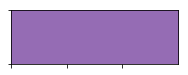

In [121]:
sns.palplot((0.5843137254901961, 0.4235294117647059, 0.7058823529411765))

In [116]:
sns.color_palette("muted")

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

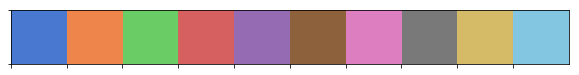

In [113]:
sns.palplot(sns.color_palette("muted"))

In [129]:
domains = ['eclipse', 'netbeans', 'openoffice'] # 'firefox' 
PREPROCESSING = 'bert'
approaches = ['baseline', 'baseline_dwen', 'deepQL_topics',
              'deepQL_trainable', 'deepQL_no_trainable', 'deepTL'] # 'DWEN_QL', 'DMS_QL', 'deepQL_weights' , 
methods = {}
authors = {}
markers = {}
colors = {
    'DMS' : (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # azul
    'DWEN' : (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), # laranja
    'DeepQL_topics' : (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # verde
    'DeepQL' : (0.5098039215686274, 0.7764705882352941, 0.8862745098039215), # azul claro
    'DeepQL_weighted' : (0.5843137254901961, 0.4235294117647059, 0.7058823529411765), # roxo
    'DeepTL' : (0.8941176470588236, 0.10196078431372549, 0.10980392156862745) # vermelho
}
approaches_names = {
    'baseline' : 'DMS',
    'DMS_QL' : 'DMS_QL',
    'baseline_dwen' : 'DWEN',
    'DWEN_QL' : 'DWEN_QL',
    'deepQL_topics' : 'DeepQL_topics',
    'deepQL_weights' : 'DeepQL_weights',
    'deepQL_no_trainable' : 'DeepQL',
    'deepQL_trainable' : 'DeepQL_weighted',
    'deepTL' : 'DeepTL'
}
approaches_symbols = {
    'baseline' : '.',
    'baseline_dwen' : '^',
    'deepQL_topics' : '<',
    'deepQL_no_trainable' : '*',
    'deepQL_weights' : '2',
    'DWEN_QL' : '>',
    'deepQL_trainable' : '4',
    'deepTL' : 'D',
    'DMS_QL' : '3'
}
epochs = ['100', '1000']
for i in epochs:
    if i not in methods:
        methods[i] = []
    for name in approaches:
        methods[i].append("{}_{}".format(name, i))
for i in epochs:
    for name in approaches:
        key = "{}_{}".format(name, i)
        authors[key] =  approaches_names[name]
for i in epochs:
    for name in approaches:
        key = "{}_{}".format(name, i)
        markers[key] =  approaches_symbols[name]

In [149]:
methods

{'100': ['baseline_100',
  'baseline_dwen_100',
  'deepQL_topics_100',
  'deepQL_trainable_100',
  'deepQL_no_trainable_100',
  'deepTL_100'],
 '1000': ['baseline_1000',
  'baseline_dwen_1000',
  'deepQL_topics_1000',
  'deepQL_trainable_1000',
  'deepQL_no_trainable_1000',
  'deepTL_1000']}

In [150]:
authors

{'baseline_100': 'DMS',
 'baseline_1000': 'DMS',
 'baseline_dwen_100': 'DWEN',
 'baseline_dwen_1000': 'DWEN',
 'deepQL_no_trainable_100': 'DeepQL',
 'deepQL_no_trainable_1000': 'DeepQL',
 'deepQL_topics_100': 'DeepQL_topics',
 'deepQL_topics_1000': 'DeepQL_topics',
 'deepQL_trainable_100': 'DeepQL_weighted',
 'deepQL_trainable_1000': 'DeepQL_weighted',
 'deepTL_100': 'DeepTL',
 'deepTL_1000': 'DeepTL'}

In [151]:
markers

{'baseline_100': '.',
 'baseline_1000': '.',
 'baseline_dwen_100': '^',
 'baseline_dwen_1000': '^',
 'deepQL_no_trainable_100': '*',
 'deepQL_no_trainable_1000': '*',
 'deepQL_topics_100': '<',
 'deepQL_topics_1000': '<',
 'deepQL_trainable_100': '4',
 'deepQL_trainable_1000': '4',
 'deepTL_100': 'D',
 'deepTL_1000': 'D'}

### Retrieval 

In [8]:
def evaluate_rank(evaluation, method, domain, epoch, aproach, recall, recall_index, epochs, datasets, symbols, path):
    #evaluation = Evaluation(0)
    try:
        if(path != ''):
            report = evaluation.evaluate(path)
        else:
            report = evaluation
        recall.append(report['0 - recall_at_1'])
        recall.append(report['1 - recall_at_5'])
        recall.append(report['2 - recall_at_10'])
        recall.append(report['3 - recall_at_15'])
        recall.append(report['4 - recall_at_20'])
        recall.append(report['5 - recall_at_25'])
        aproach += [authors[method]] * 6
        symbols += [markers[method]] * 6
        datasets += [domain] * 6
        epochs += [epoch] * 6
        recall_index += [1, 5, 10, 15, 20, 25]
        print(path)
        return report
    except Exception as e:
        print(e)
        print("Does not exist result for: {}".format(path))
        return
def create_dataframe(rank):
    recall = [] # recall binary
    recall_classic = [] # recall with groundtruth
    precision = []
    fscore = []
    fscore_classic = []
    aproach, recall_index, datasets, epochs, symbols = [], [], [], [], []
    df = pd.DataFrame(columns=['recall', 'precision', 'f_score', 'top@k', 'method', 'domain', 'epoch', 'symbol'])

    for epoch in ['100', '1000']:
        for domain in domains:
            # Domain to use
            DOMAIN = domain
            # Dataset paths
            DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
            for method in methods[epoch]:
                path = os.path.join(DIR, '{}_{}.txt'.format(rank, method))
                report_recall = evaluate_rank(Evaluation(0), method, domain, epoch, aproach, recall, recall_index, epochs, datasets, symbols, path)
                report_precision = evaluate_rank(EvaluationPrecision(0), method, domain, epoch, [], precision, [], [], [], [], path)
#                 report_recall_classic = evaluate_rank(EvaluationRecall(0), epoch, domain, recall_classic, [], path)
                if(report_precision != None and report_recall != None):
                    report_fscore = evaluate_rank(EvaluationFscore().evaluate(report_precision, report_recall), method, domain, epoch, [], fscore, [], [], [], [], '')
    
    df['recall'] = recall
    df['precision'] = precision
    df['f_score'] = fscore
    df['top@k'] = recall_index
    df['method'] = aproach
    df['domain'] = datasets
    df['epoch'] = epochs
    df['symbol'] = symbols
    return df

In [9]:
df = create_dataframe('exported_rank')
df_master = create_dataframe('exported_rank_master')

data/processed/eclipse/bert/exported_rank_baseline_100.txt
data/processed/eclipse/bert/exported_rank_baseline_100.txt

data/processed/eclipse/bert/exported_rank_baseline_dwen_100.txt
data/processed/eclipse/bert/exported_rank_baseline_dwen_100.txt

data/processed/eclipse/bert/exported_rank_deepQL_topics_100.txt
data/processed/eclipse/bert/exported_rank_deepQL_topics_100.txt

data/processed/eclipse/bert/exported_rank_deepQL_trainable_100.txt
data/processed/eclipse/bert/exported_rank_deepQL_trainable_100.txt

data/processed/eclipse/bert/exported_rank_deepQL_no_trainable_100.txt
data/processed/eclipse/bert/exported_rank_deepQL_no_trainable_100.txt

data/processed/eclipse/bert/exported_rank_deepTL_100.txt
data/processed/eclipse/bert/exported_rank_deepTL_100.txt

data/processed/netbeans/bert/exported_rank_baseline_100.txt
data/processed/netbeans/bert/exported_rank_baseline_100.txt

data/processed/netbeans/bert/exported_rank_baseline_dwen_100.txt
data/processed/netbeans/bert/exported_rank_bas

### Markers

https://matplotlib.org/3.1.1/api/markers_api.html

# Duplicate Test

In [135]:
import matplotlib.ticker as mticker
import seaborn as sns

MEDIUM_SIZE = 16
SMALL_SIZE = 14

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels

#plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
def plot_retrieval(metric, df, name='retrieval_1000', aproachs=['DeepQL_topics', 'DeepQL_weighted', 'DeepQL', 'DeepTL', 'DMS', 'DWEN']):
    # equivalent but more general
    fig, axes = plt.subplots(nrows=1, ncols=len(domains), figsize=(22, 5))

    for index, domain in enumerate(domains):
        #aproachs = df['method'].unique()
        for i, method in enumerate(aproachs):
            color = colors[method]
            experiment = df[(df['method'] == method) & (df['domain'] == domain)]
            if experiment.shape[0] > 0:
                experiment.plot(x='top@k', y=metric, label=method, ax=axes[index], 
                                marker=experiment['symbol'].values[0], markersize=12, color=color)

        axes[index].set_ylabel('{} Rate'.format(metric))
        axes[index].set_xlabel('K')
        text = axes[index].set_title('{}'.format(domain))
        lgd = axes[index].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18))
        formatter = mticker.ScalarFormatter()
        axes[index].xaxis.set_major_formatter(formatter)
        axes[index].xaxis.set_major_locator(mticker.FixedLocator([1, 5, 10, 15, 20, 25]))
        axes[index].grid(True, axis='y', alpha=.5)

    fig.savefig('{}.png'.format(name), bbox_inches="tight")

## 100 epochs

In [10]:
df_100 = df[df['epoch'] == '100']

### All methods

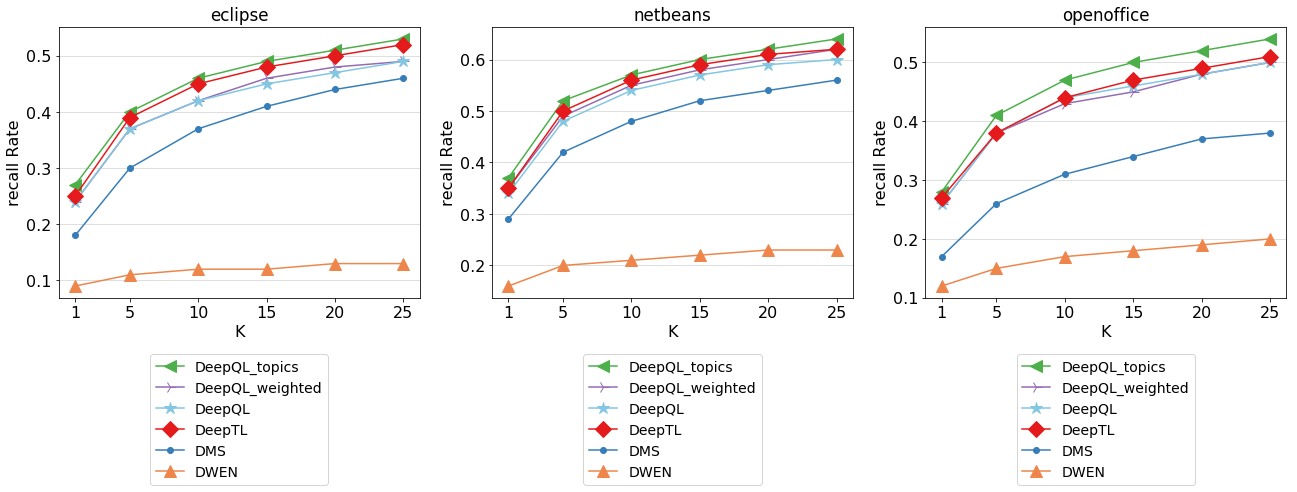

In [141]:
plot_retrieval('recall', df_100, 'retrieval_100')

In [13]:
df_100[df_100['domain'] == 'eclipse']

,recall,precision,f_score,top@k,method,domain,epoch,symbol
0,0.18,0.18,0.18,1,DMS,eclipse,100,.
1,0.30,0.10,0.15,5,DMS,eclipse,100,.
2,0.37,0.07,0.12,10,DMS,eclipse,100,.
3,0.41,0.06,0.10,15,DMS,eclipse,100,.
4,0.44,0.05,0.09,20,DMS,eclipse,100,.
5,0.46,0.05,0.09,25,DMS,eclipse,100,.
6,0.09,0.09,0.09,1,DWEN,eclipse,100,^
7,0.11,0.04,0.06,5,DWEN,eclipse,100,^
8,0.12,0.02,0.03,10,DWEN,eclipse,100,^
9,0.12,0.02,0.03,15,DWEN,eclipse,100,^


## 1000 epochs

In [14]:
df_1000 = df[df['epoch'] == '1000']

## All methods

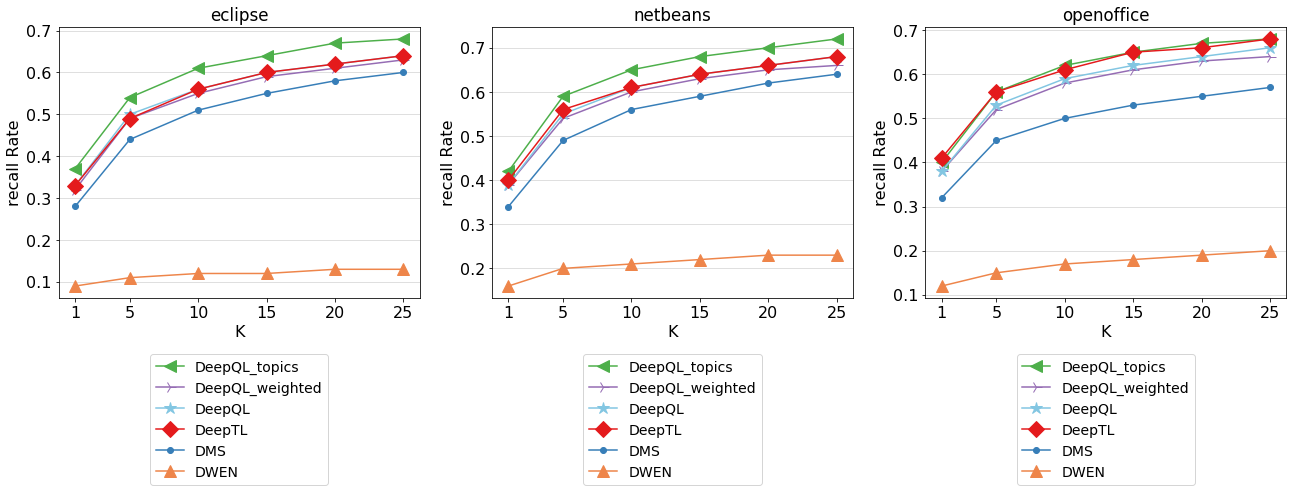

In [140]:
plot_retrieval('recall', df_1000, 'retrieval_1000')

## All baselines against best propose

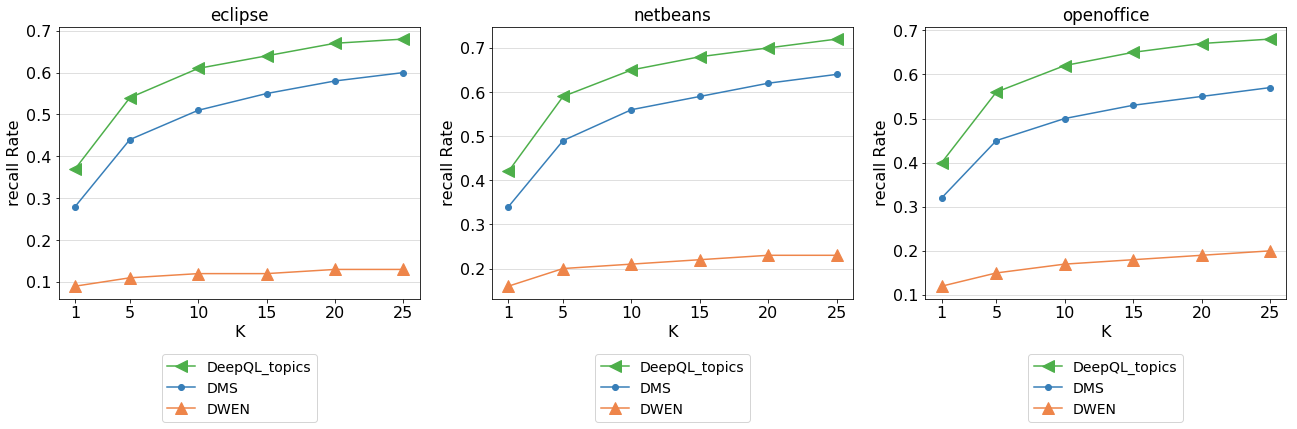

In [138]:
plot_retrieval('recall', df_1000, 'retrieval_1000_only_best_propose', ['DeepQL_topics', 'DMS', 'DWEN'])

### Only propose methods

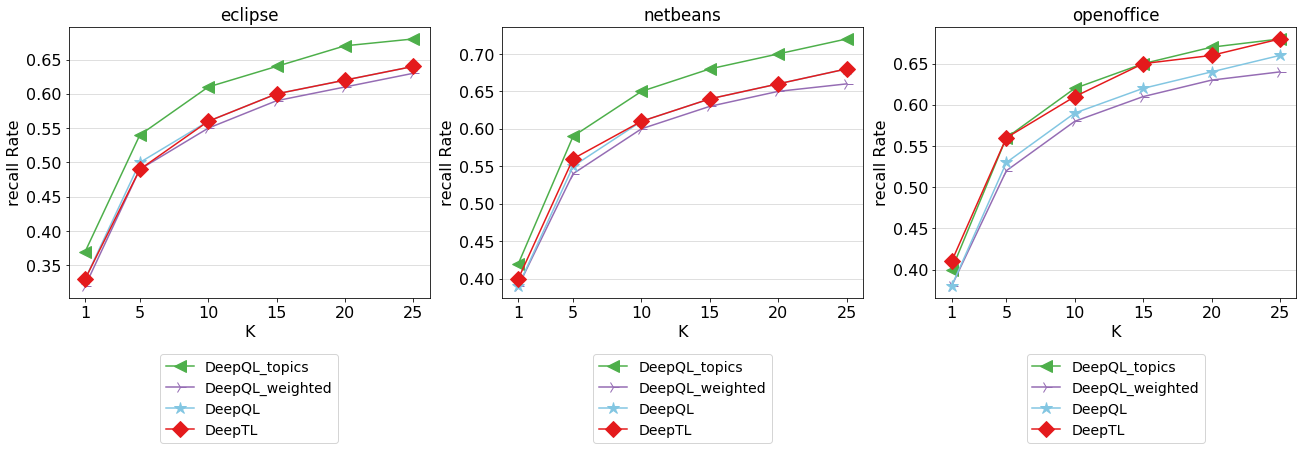

In [139]:
plot_retrieval('recall',  df_1000, 'retrieval_1000_only_proposes', ['DeepQL_topics', 'DeepQL_weighted', 'DeepQL', 'DeepTL'])

In [17]:
df_1000[df_1000['domain'].isin(['eclipse'])]

,recall,precision,f_score,top@k,method,domain,epoch,symbol
108,0.28,0.28,0.28,1,DMS,eclipse,1000,.
109,0.44,0.16,0.23,5,DMS,eclipse,1000,.
110,0.51,0.12,0.19,10,DMS,eclipse,1000,.
111,0.55,0.10,0.17,15,DMS,eclipse,1000,.
112,0.58,0.08,0.14,20,DMS,eclipse,1000,.
113,0.60,0.07,0.13,25,DMS,eclipse,1000,.
114,0.09,0.09,0.09,1,DWEN,eclipse,1000,^
115,0.11,0.04,0.06,5,DWEN,eclipse,1000,^
116,0.12,0.02,0.03,10,DWEN,eclipse,1000,^
117,0.12,0.02,0.03,15,DWEN,eclipse,1000,^


## Cluster Evaluation

In [164]:
data_clusters = []
for domain in domains:
    PREPROCESSING = 'bert'
    DIR = 'data/processed/{}/{}'.format(domain, PREPROCESSING)
    for method in methods['1000']:
        CLUSTER_PATH = 'cluster_{}.pkl'.format(method)
        try:
            with open(os.path.join(DIR, CLUSTER_PATH), 'rb') as f:
                data = pickle.load(f)
                data['domain'] = domain
                data_clusters.append(data)
        except:
            continue
df_clusters = pd.DataFrame(data_clusters)
df_clusters

,clusters,domain,method,silhouette
0,8560,eclipse,baseline_1000,-0.021004
1,8560,eclipse,deepQL_topics_1000,0.017103
2,8560,eclipse,deepQL_no_trainable_1000,0.004186


## Loss evaluation

In [18]:
import _pickle as pickle

def load_loss(method, base):
    loss_dir = 'data/processed/{}/{}'.format(base, 'bert')
    loss_dir = os.path.join(loss_dir,'{}_log.pkl'.format(method))

    with open(loss_dir, 'rb') as f:
        loss = pickle.load(f)
    return loss

In [19]:
 def validation_loss(loss, val_loss):
        plt.plot(loss, label='loss')
        plt.plot(val_loss, label='val_loss')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
def validation_loss_grid(loss, val_loss, name, lines, col, index):
        ax = plt.subplot(lines, col, index)
        plt.plot(loss, label='loss')
        plt.plot(val_loss, label='val_loss')
        plt.title(name)
        plt.ylabel('loss')
        plt.xlabel('epoch')
        if(index == 1 or (index % col == 1)):
            plt.legend(['train', 'test'], bbox_to_anchor=(-1.05, 1.0), loc='upper left')
        plt.grid(True)
        return ax

In [20]:
def plot_loss(base, epochs, limit_epochs=1000):

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(22, 20))

    index_grid = 1
    for row, model in enumerate(['deepQL_no_trainable_{}'.format(epochs),
                                 'deepQL_trainable_{}'.format(epochs),
                                 'baseline_{}'.format(epochs),
                                 'DMS_QL_{}'.format(epochs), 
                                 'DWEN_QL_{}'.format(epochs),
                                'deepTL_{}'.format(epochs)]):
        try:
            ql_loss = load_loss(model, base)
            for _, (loss_name, index) in enumerate(zip(['loss', 'Q1', 'Q2', 'Q3', 'Q4'], [0, 5, 6, 7, 8])):
                try:
                    train = [r[index] for r in ql_loss['train']][:limit_epochs]
                    test = [r[index] for r in ql_loss['test']][:limit_epochs]
                    ax_r = validation_loss_grid(train, test, loss_name, n_rows, n_cols, index_grid)
                    if(index_grid == 1 or (index_grid % n_cols == 1)):
                        ax = ax_r
                except: pass
                index_grid+=1
            
            plt.text(0, 1.5, model,
                 horizontalalignment='center',
                 verticalalignment='center',
                 transform=ax.transAxes,
                 fontsize=20)
        except:
            pass


    plt.subplots_adjust(hspace=1.25,
                        wspace=0.35)
    plt.show()

In [21]:
n_rows = 6
n_cols = 5
limit_epochs = 200
epochs = 1000

In [22]:
import numpy as np

np.asarray([[1]]).shape, np.asarray([[.5]]).shape
#np.asarray([[1]]) * np.asarray([[.5]])

((1, 1), (1, 1))

### Eclipse 

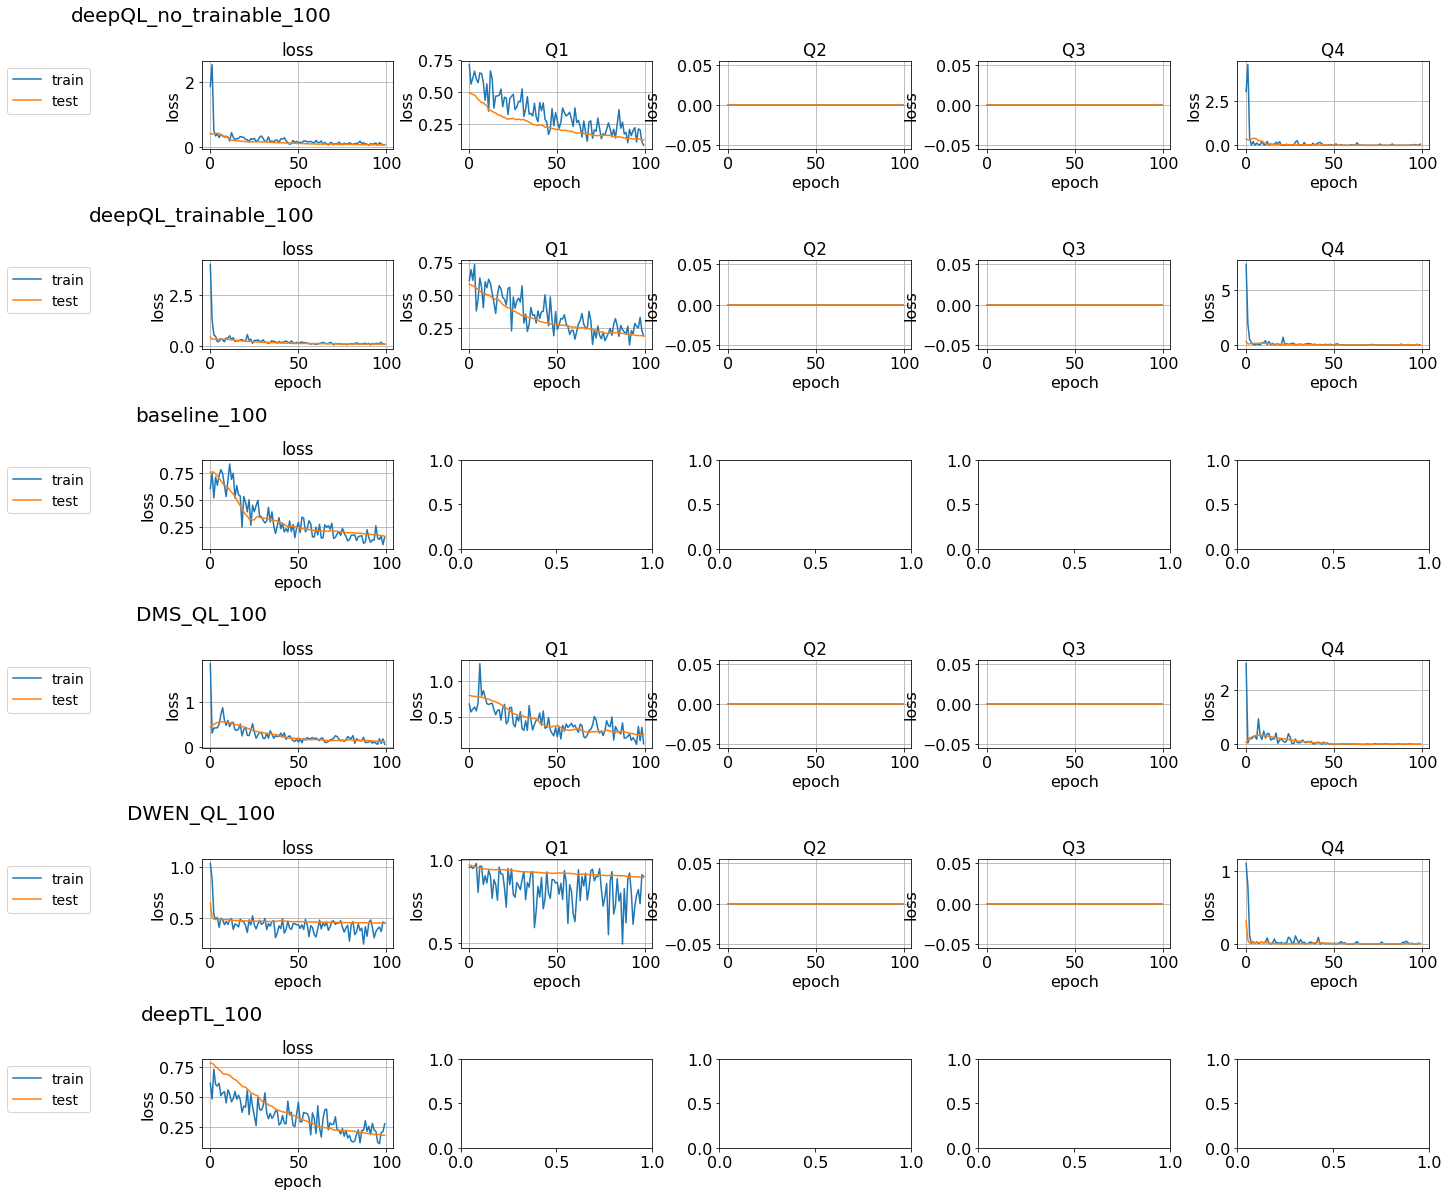

In [23]:
plot_loss('eclipse', 100, limit_epochs=100)

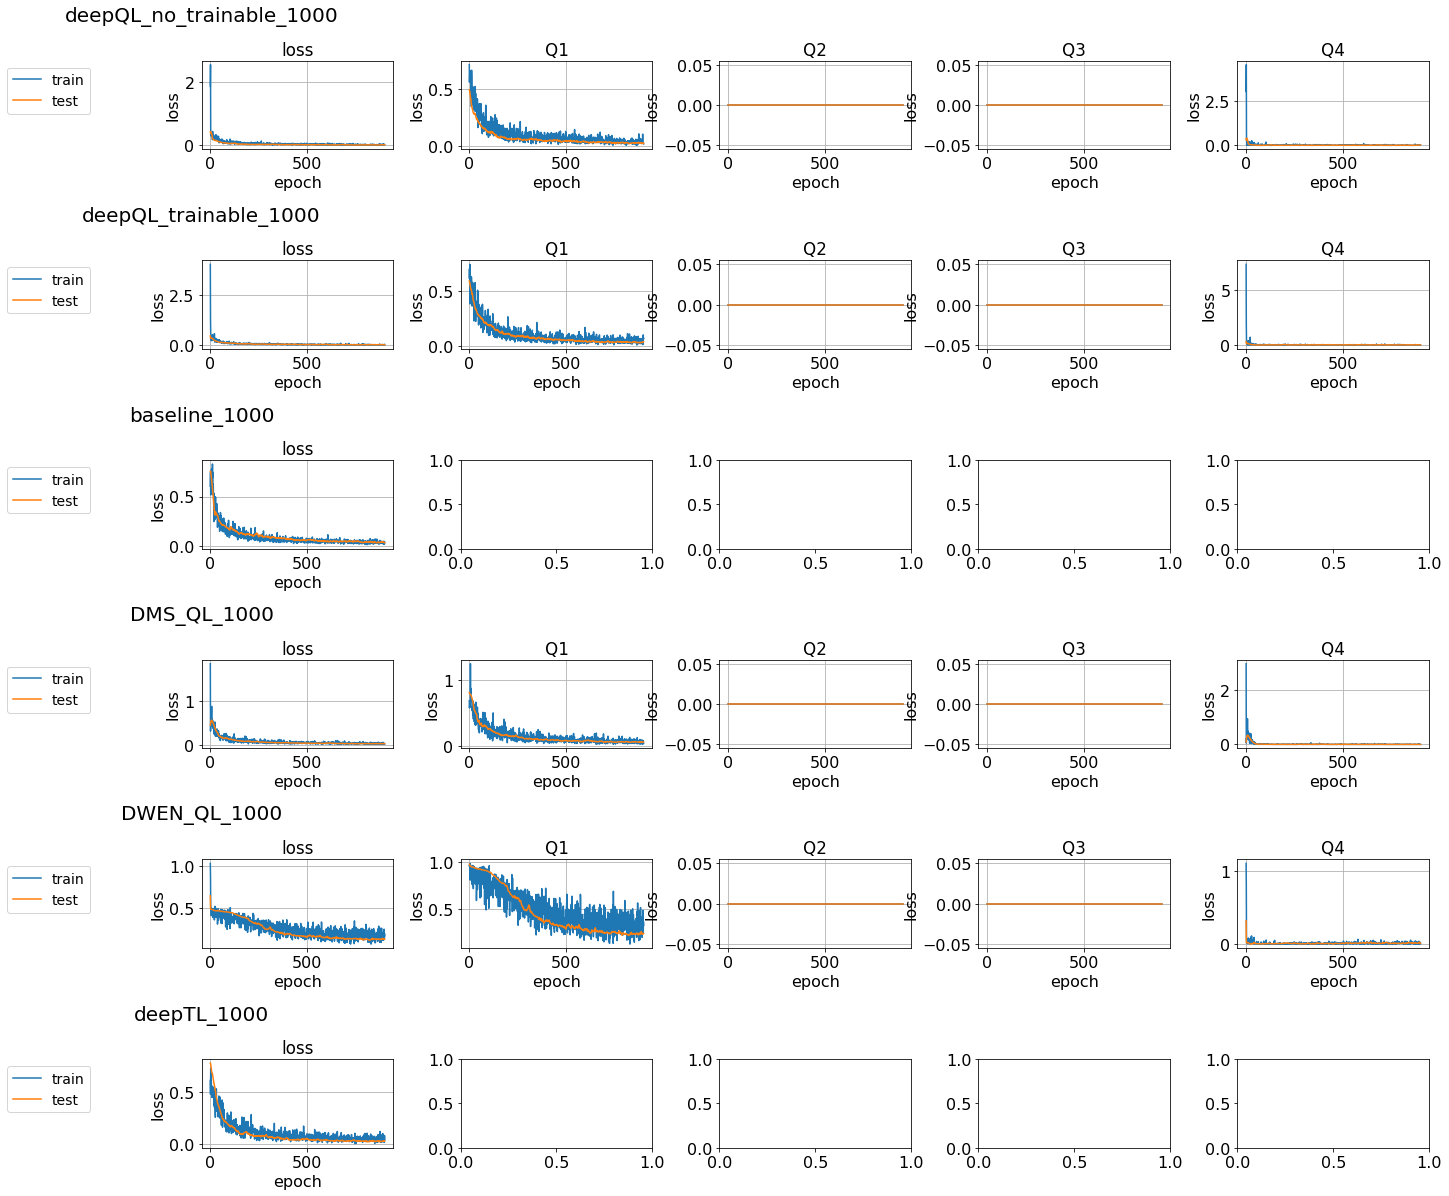

In [24]:
plot_loss('eclipse', 1000)

### Netbeans

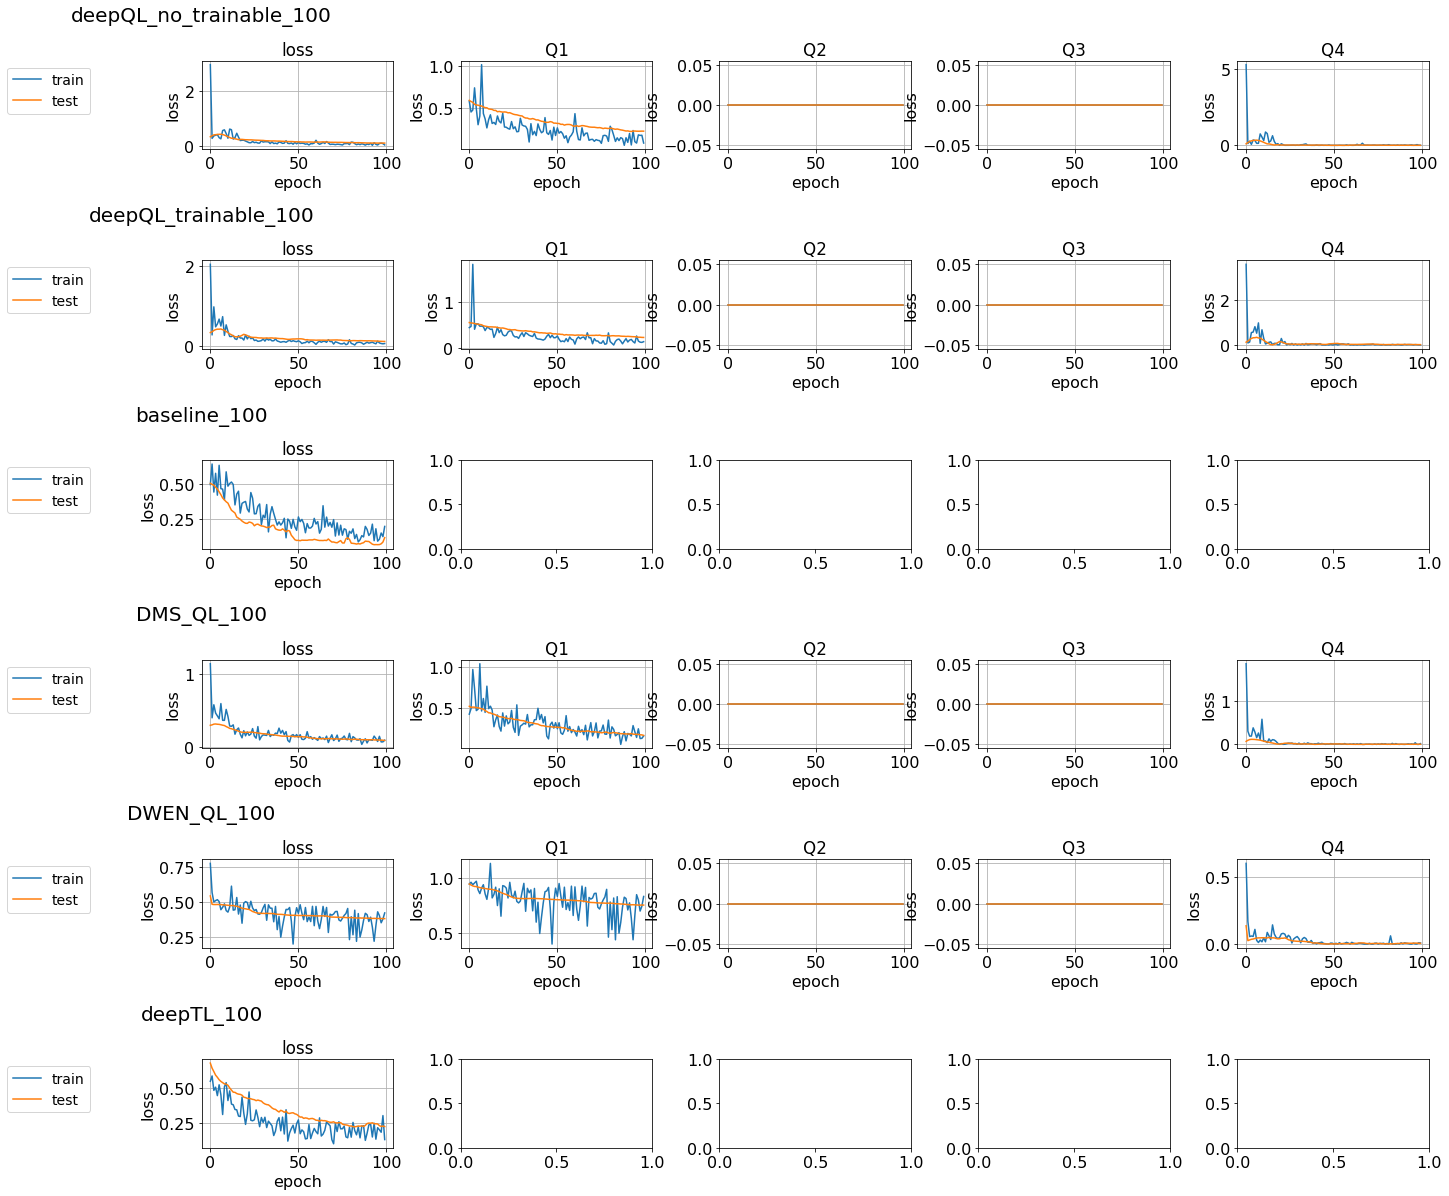

In [25]:
plot_loss('netbeans', 100, limit_epochs=100)

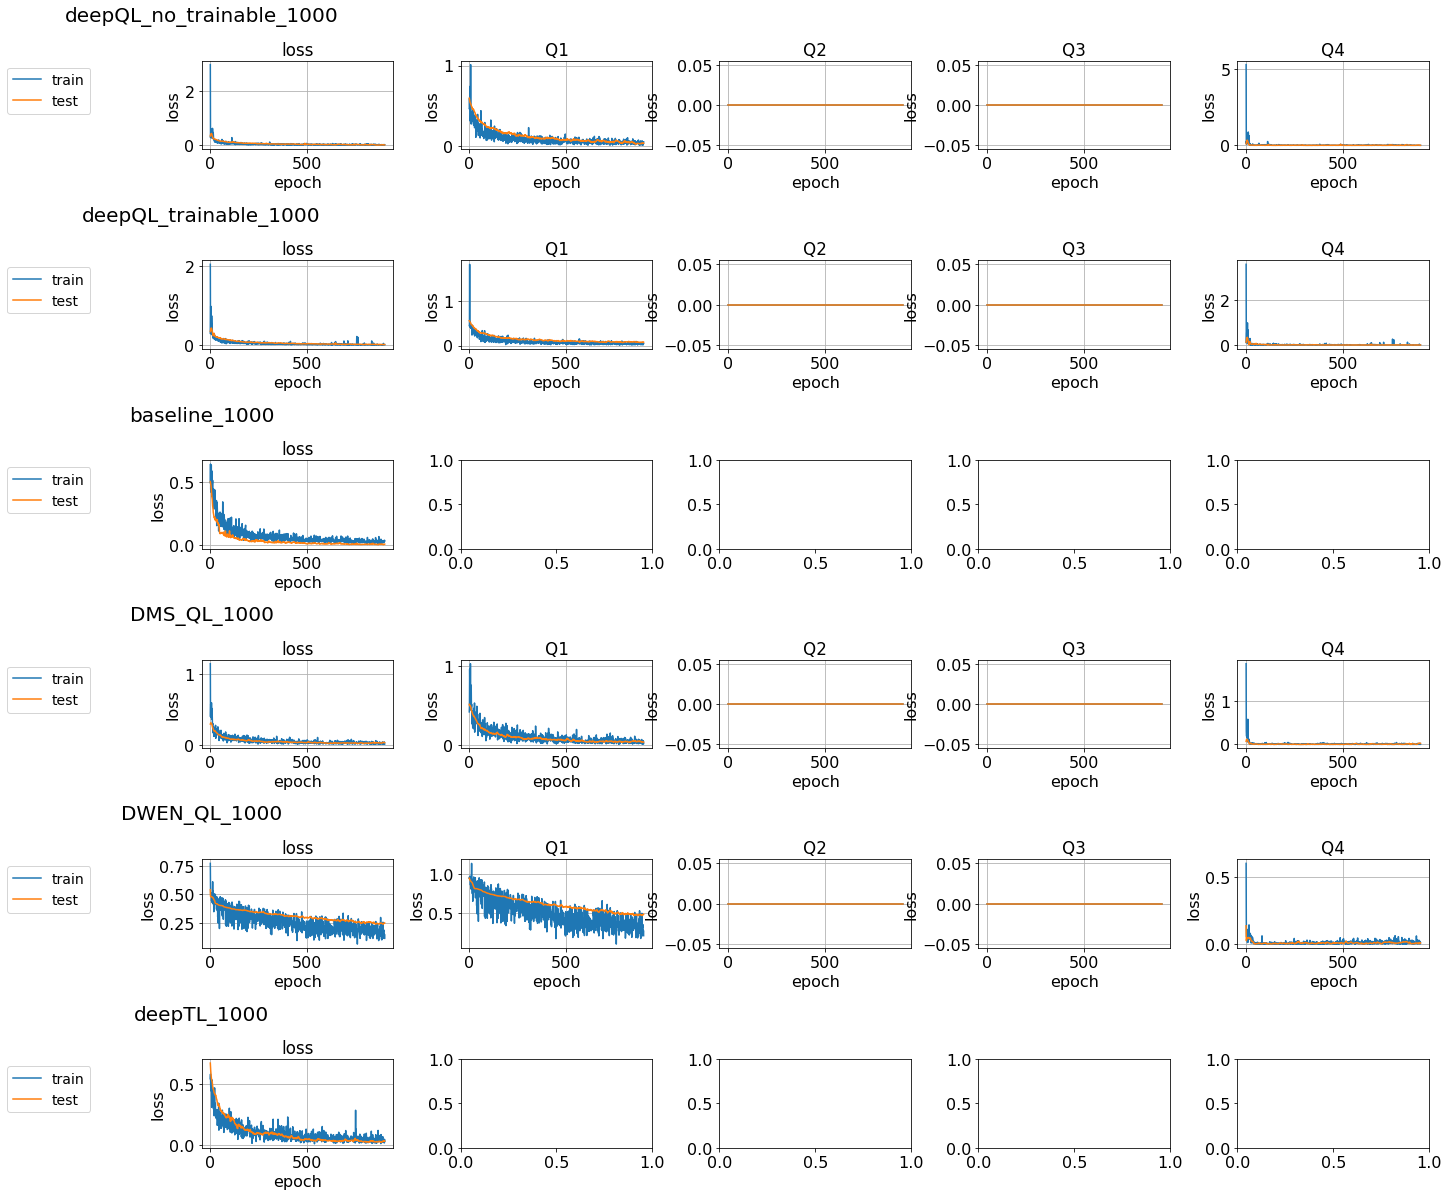

In [26]:
plot_loss('netbeans', epochs)

### Open Office

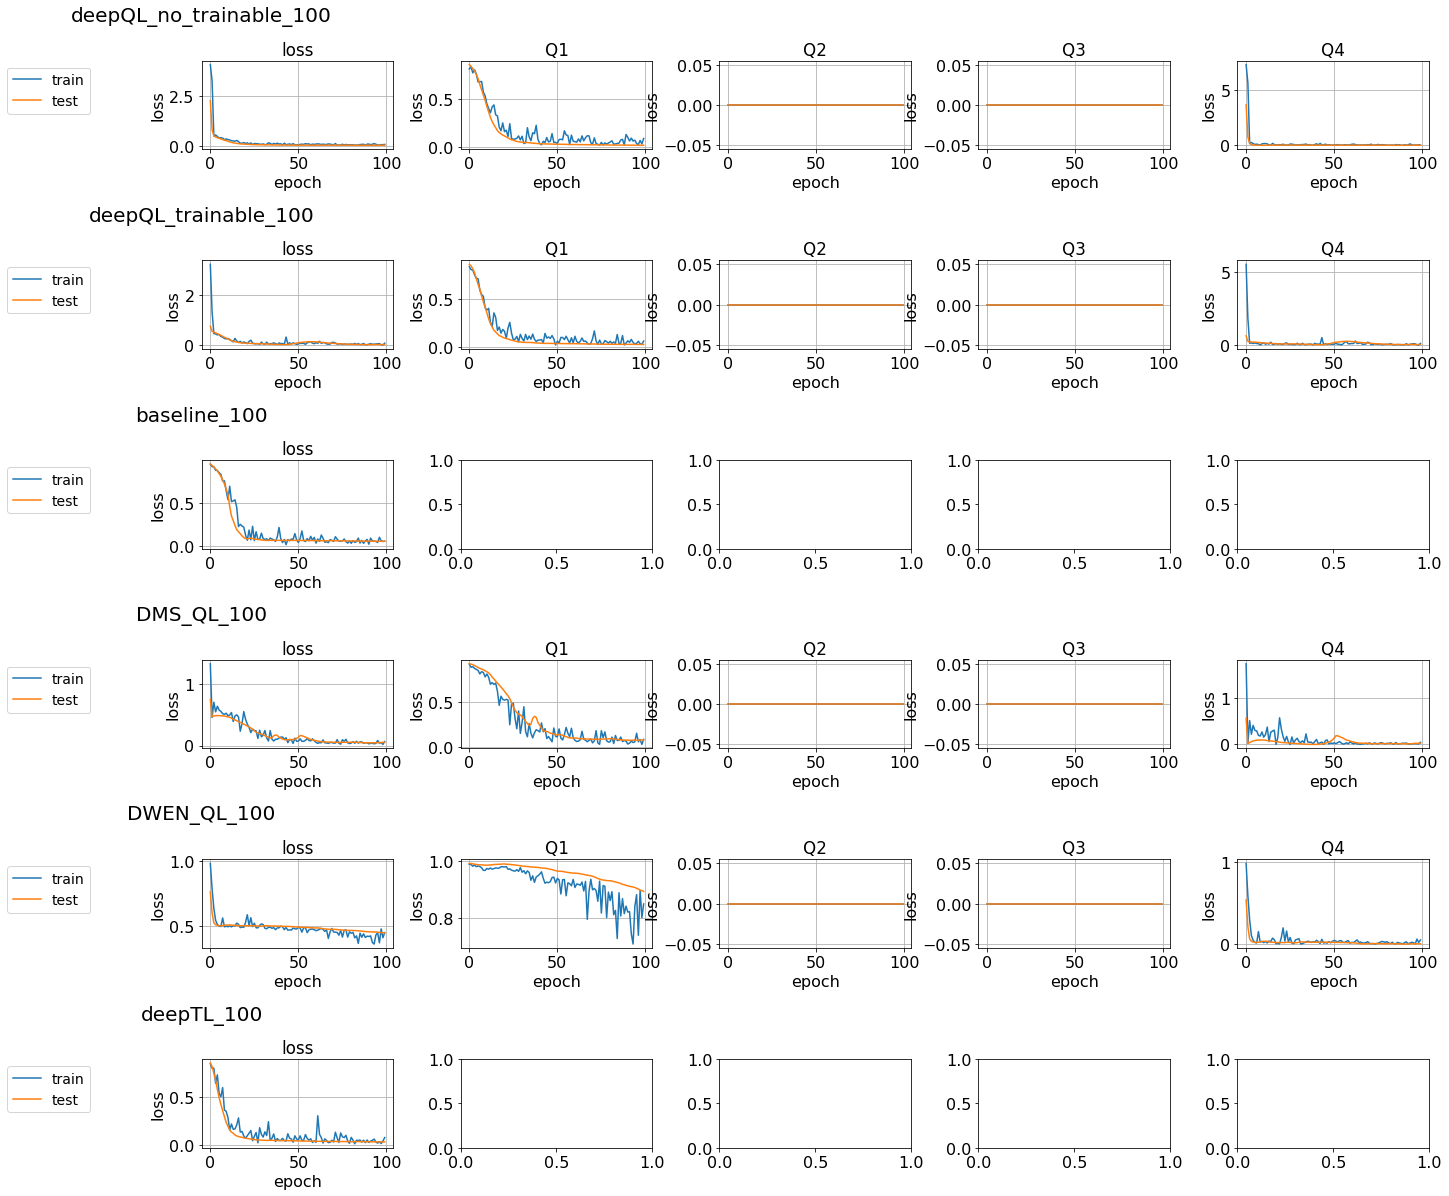

In [27]:
plot_loss('openoffice', 100, limit_epochs=100)

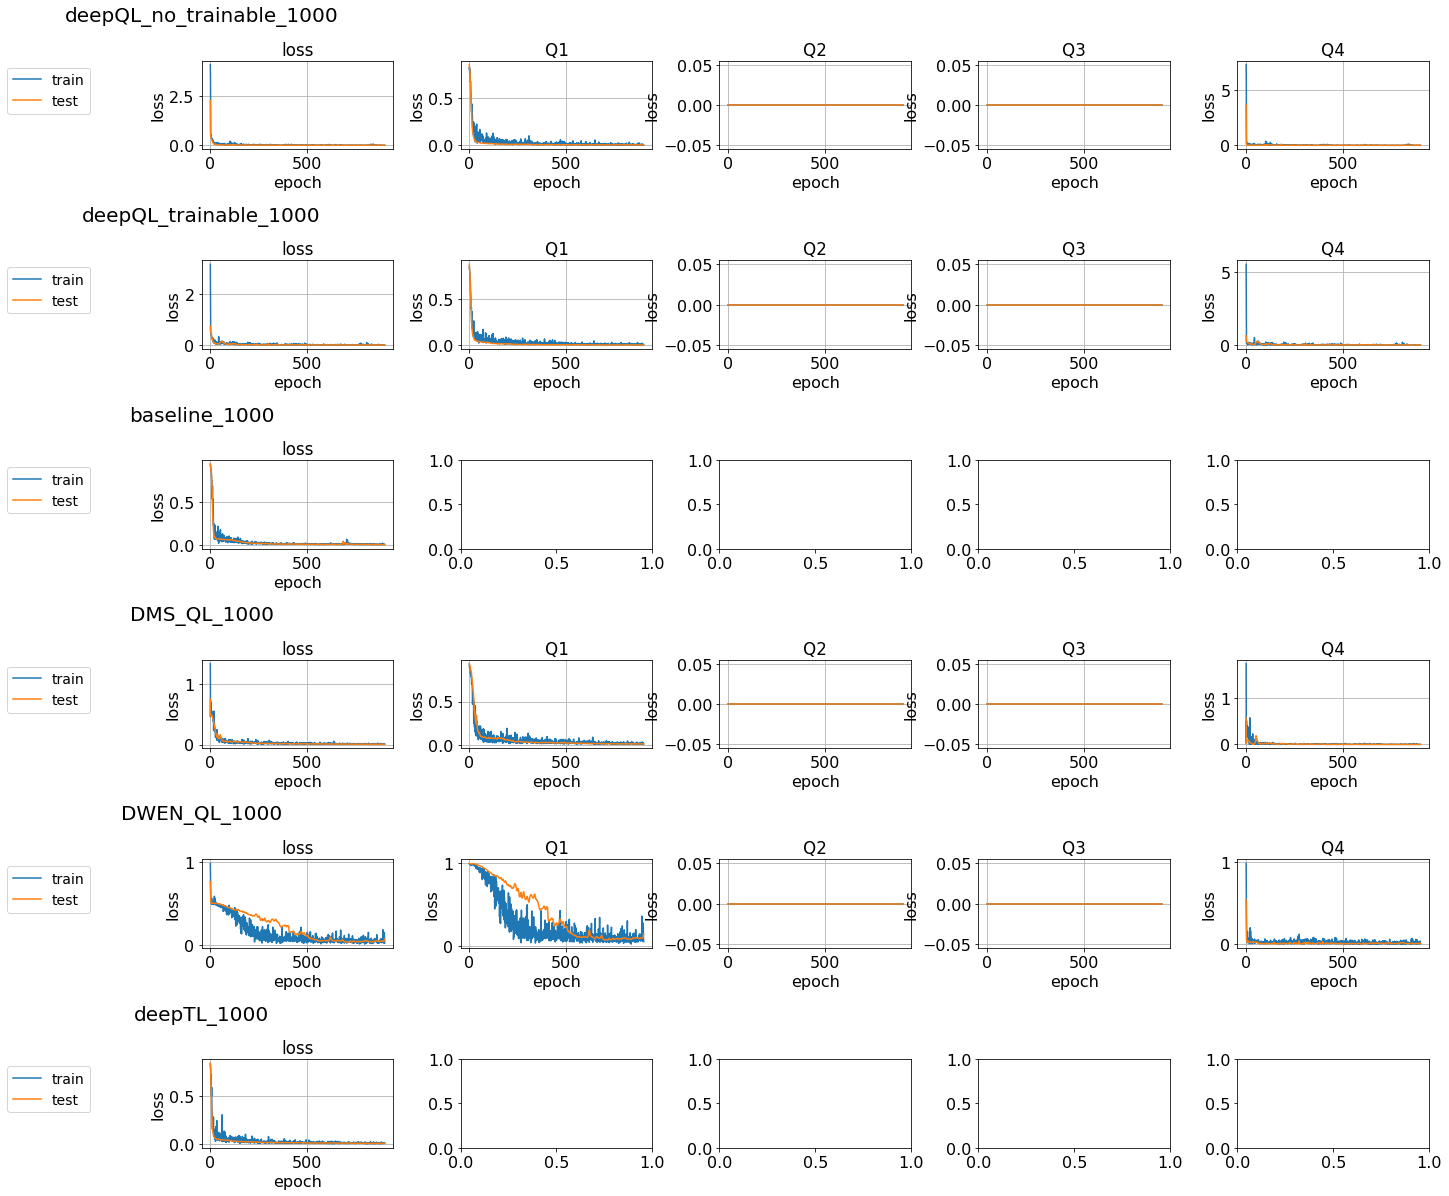

In [28]:
plot_loss('openoffice', 1000)

### How TL is the most important during the learning?

Count how many time a model choiced a loss as the most important loss.

In [142]:
'''
    deepQL_weights_1000
    deepQL_trainable_1000
    DMS_QL_1000
    DWEN_QL_1000
    deepTL_100
'''
loss_data = load_loss('deepQL_trainable_1000', 'netbeans')

In [143]:
import numpy as np
import collections

train = loss_data['train']
test = loss_data['test']

w_name = {
    0 : 'Q1',
    1 : 'Q2',
    2 : 'Q3',
    3 : 'Q4'
}

def high_importance(w):
    index = np.argmax(w, axis=0)
    return w_name[index]
def low_importance(w):
    index = np.argmin(w, axis=0)
    return w_name[index]
def equal_importance(w):
    c = collections.Counter(w)
    c = [r[0] for r in c.most_common(4) if r[1] > 1]
    def get_name(arr):
        name = [w_name[e] for e in arr]
        return ",".join(name)
    names = [get_name(np.where(np.asarray(w) == e)[0]) for e in c]
    return ",".join(names) if len(names) > 0 else "none"

loss_status = { 'train' : {}, 'test' : {} }
for data, phase in zip([train, test], ['train', 'test']):
    loss_status[phase]['high'] = [high_importance(r[1:5]) for r in data]
    loss_status[phase]['low'] = [low_importance(r[1:5]) for r in data]
    loss_status[phase]['equal'] = [equal_importance(r[1:5]) for r in data]

loss_status.keys()

dict_keys(['test', 'train'])

In [144]:
import matplotlib.pyplot as plt

def summary_loss(loss_status, phase, index, index_name):
    data = [ np.concatenate([[loss_status[phase]['high'][take_epoch], loss_status[phase]['low'][take_epoch], 
                              loss_status[phase]['equal'][take_epoch]],
                            train[take_epoch][1:5]])
            for take_epoch in index]
    index = ["{} epoch(s)".format(n) for n in index_name]
    return pd.DataFrame(data=data, columns=['high', 'low', 'equal', 'Q1', 'Q2', 'Q3', 'Q4'], index=index)

def plot_importance(loss_status, phase, list_importance):
    data = []
    for importance in list_importance:
        name = '{}_importance'.format(importance)
        stats_loss = pd.DataFrame(data=loss_status[phase][importance], columns=[name])
        n_rows = stats_loss.shape[0]
        stats_loss = stats_loss.groupby(by=[name]).agg(arg=name).count().to_frame()
        stats_loss[name] = stats_loss[name] / n_rows
        stats_loss['importance'] = importance
        data.append(stats_loss)
    merged = pd.concat(data, sort=True)
    plt.figure();
    merged.plot.bar(by='importance')

#### Summarize loss importance on train at 1, 10, 100 and 1000 epochs

In [145]:
index = [0, 9, 99, 899]
index_name = [1, 10, 100, 1000]
phase = 'train'
summary_loss(loss_status, phase, index, index_name)

,high,low,equal,Q1,Q2,Q3,Q4
1 epoch(s),Q1,Q1,"Q1,Q2,Q3,Q4",1.0,1.0,1.0,1.0
10 epoch(s),Q1,Q4,"Q2,Q3",1.0020972,1.0,1.0,0.9979062
100 epoch(s),Q4,Q1,"Q2,Q3",0.97378725,1.0,1.0,1.0257359
1000 epoch(s),Q4,Q1,"Q2,Q3",0.3507811,1.0,1.0,1.4711956


<Figure size 432x288 with 0 Axes>

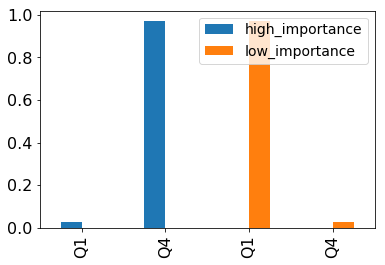

In [146]:
plot_importance(loss_status, phase, ['high', 'low'])

#### Summarize loss importance on test at 1, 10, 100 and 1000 epochs

In [147]:
index = [0, 9, 99, 899]
index_name = [1, 10, 100, 1000]
phase = 'test'
summary_loss(loss_status, phase, index, index_name)

,high,low,equal,Q1,Q2,Q3,Q4
1 epoch(s),Q1,Q4,"Q2,Q3",1.0,1.0,1.0,1.0
10 epoch(s),Q1,Q4,"Q2,Q3",1.0020972,1.0,1.0,0.9979062
100 epoch(s),Q4,Q1,"Q2,Q3",0.97378725,1.0,1.0,1.0257359
1000 epoch(s),Q4,Q1,"Q2,Q3",0.3507811,1.0,1.0,1.4711956


<Figure size 432x288 with 0 Axes>

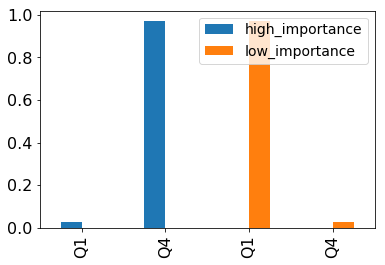

In [148]:
plot_importance(loss_status, phase, ['high', 'low'])

### Visualize indivual loss for a model

In [36]:
'''
    deepQL_weights_1000
    deepQL_trainable_1000
    DMS_QL_1000
    DWEN_QL_1000
    deepTL_100
'''
ql_loss = load_loss('deepQL_weights_1000', 'openoffice')

In [37]:
len(ql_loss['train'])

900

#### Triplet Loss with weights

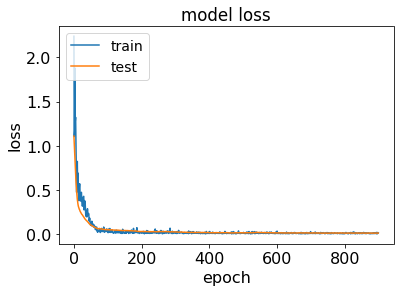

In [38]:
train = [r[0] for r in ql_loss['train']]
test = [r[0] for r in ql_loss['test']]
validation_loss(train, test)

#### Triplet loss

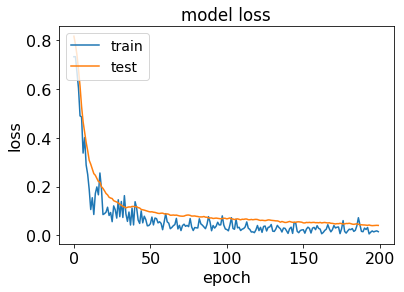

In [39]:
train = [r[5] for r in ql_loss['train']][:limit_epochs]
test = [r[5] for r in ql_loss['test']][:limit_epochs]

validation_loss(train, test)

#### Triplet loss pos

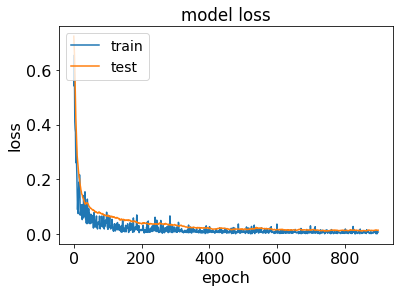

In [40]:
train = [r[6] for r in ql_loss['train']]
test = [r[6] for r in ql_loss['test']]

validation_loss(train, test)

#### Triplet loss neg

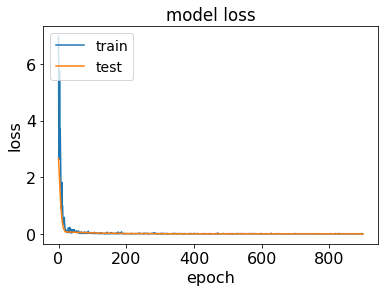

In [41]:
train = [r[7] for r in ql_loss['train']]
test = [r[7] for r in ql_loss['test']]

validation_loss(train, test)

#### Triplet loss centroids

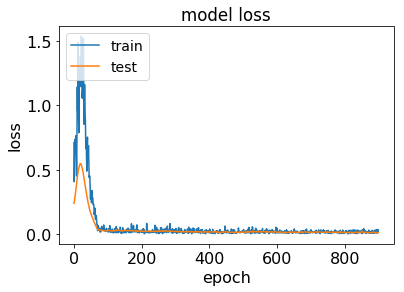

In [42]:
train = [r[8] for r in ql_loss['train']]
test = [r[8] for r in ql_loss['test']]

validation_loss(train, test)

### Classification

In [161]:
import _pickle as pickle

rows = []

for epoch in ['1000']:
    for domain in domains:
        # Dataset paths
        DIR = 'data/processed/{}/{}/'.format(domain, PREPROCESSING)

        for method in methods[epoch]:
            path = os.path.join(DIR, 'classification_{}.pkl'.format(method))

            try:
                with open(path, 'rb') as f:
                    result = pickle.load(f)

                print(path)

                rows.append({ 'autor': authors[result['method']], 'acurácia' : round(result['acc_test'], 2), 'roc/auc' : round(result['roc_test'], 2),  
                             'domain' : domain })
            except:
                print("Does not exist result for: {}".format(path))
                pass
    
df_cls = pd.DataFrame(data=rows, columns=['autor', 'acurácia', 'roc/auc', 'domain'])

data/processed/eclipse/bert/classification_baseline_1000.pkl
data/processed/eclipse/bert/classification_baseline_dwen_1000.pkl
data/processed/eclipse/bert/classification_deepQL_topics_1000.pkl
data/processed/eclipse/bert/classification_deepQL_trainable_1000.pkl
data/processed/eclipse/bert/classification_deepQL_no_trainable_1000.pkl
data/processed/eclipse/bert/classification_deepTL_1000.pkl
data/processed/netbeans/bert/classification_baseline_1000.pkl
data/processed/netbeans/bert/classification_baseline_dwen_1000.pkl
data/processed/netbeans/bert/classification_deepQL_topics_1000.pkl
data/processed/netbeans/bert/classification_deepQL_trainable_1000.pkl
data/processed/netbeans/bert/classification_deepQL_no_trainable_1000.pkl
data/processed/netbeans/bert/classification_deepTL_1000.pkl
data/processed/openoffice/bert/classification_baseline_1000.pkl
data/processed/openoffice/bert/classification_baseline_dwen_1000.pkl
data/processed/openoffice/bert/classification_deepQL_topics_1000.pkl
data/p

In [162]:
df_cls

,autor,acurácia,roc/auc,domain
0,DMS,0.95,0.99,eclipse
1,DWEN,0.67,0.73,eclipse
2,DeepQL_topics,0.95,0.99,eclipse
3,DeepQL_weighted,0.94,0.99,eclipse
4,DeepQL,0.95,0.99,eclipse
5,DeepTL,0.93,0.98,eclipse
6,DMS,0.95,0.99,netbeans
7,DWEN,0.71,0.79,netbeans
8,DeepQL_topics,0.95,0.99,netbeans
9,DeepQL_weighted,0.94,0.99,netbeans


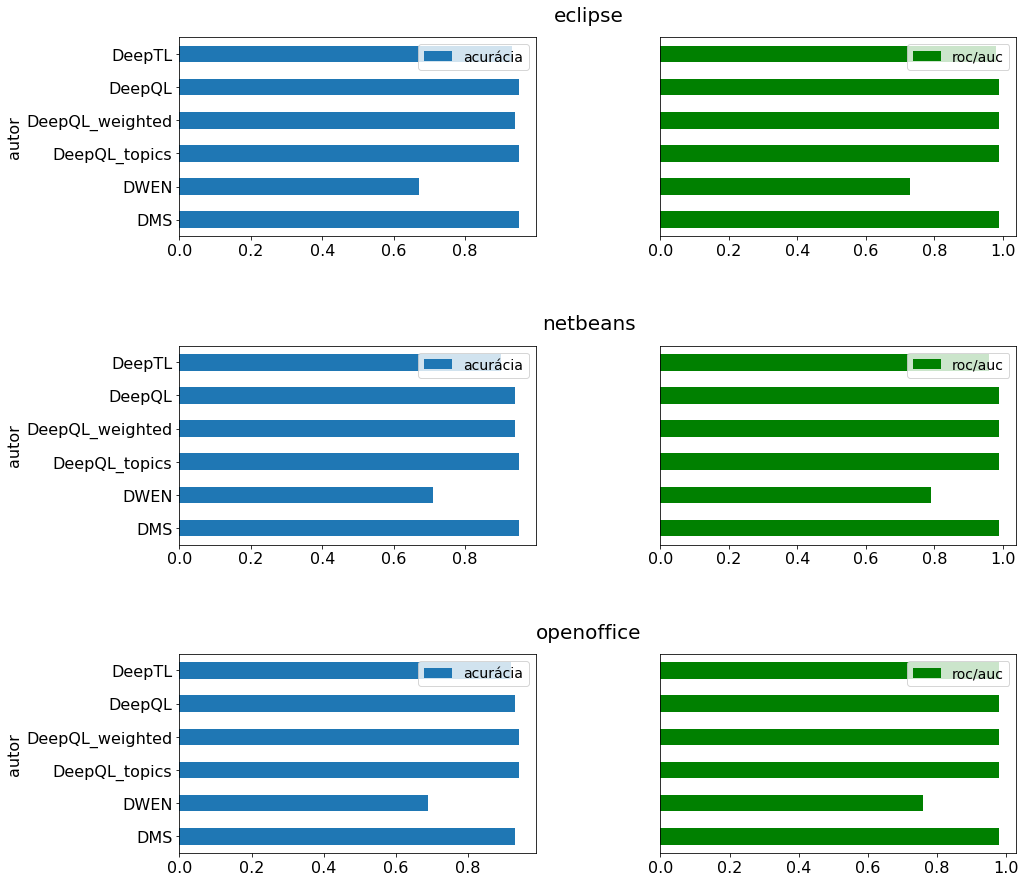

In [163]:
fig, axes = plt.subplots(nrows=len(domains), ncols=2, figsize=(15, 15))

for row, domain in enumerate(domains): 
    plt.text(1.15, 1.08, domain,
         horizontalalignment='center',
         fontsize=20,
         transform = axes[row, 0].transAxes)
    ax = df_cls[df_cls['domain'] == domain].set_index('autor')[['acurácia']].plot.barh(ax=axes[row, 0])
    #ax.set_title(domain)
    ax = df_cls[df_cls['domain'] == domain].set_index('autor')[['roc/auc']].plot.barh(ax=axes[row, 1], color='g')
    ax.get_yaxis().set_visible(False)
    #ax.set_title(domain)
    
plt.subplots_adjust(hspace=0.55,
                    wspace=0.35)